In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# -------------------- DATASET PREPARATION --------------------

# Define dataset paths (Replace with your actual path)
DATA_DIR = r"C:\Users\farah\Desktop\ModelsTypesRun\new updates"
TRAIN_DIR = os.path.join(r"C:\Users\farah\Desktop\ModelsTypesRun", "train3")
VAL_DIR = os.path.join(r"C:\Users\farah\Desktop\ModelsTypesRun", "val3")
TEST_DIR = os.path.join(r"C:\Users\farah\Desktop\ModelsTypesRun", "test3")

# Class names (Ensure these match actual folder names inside DATA_DIR)
CLASS_NAMES = ["new mild", "new moderate", "new severe"]  # Change if needed

# Image parameters
IMG_SIZE = (331, 331)  # NASNetLarge recommended input size
BATCH_SIZE = 32  # Adjust as needed
EPOCHS = 20  # Number of training epochs
LEARNING_RATE = 0.0001  # Optimizer learning rate

# Function to prepare dataset
def prepare_dataset(data_dir, train_dir, val_dir, test_dir, train_split=0.7, val_split=0.15):
    """ Splits dataset into train, validation, and test sets. """
    
    # Delete old directories and recreate them
    for dir_path in [train_dir, val_dir, test_dir]:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.makedirs(dir_path, exist_ok=True)

    for class_name in CLASS_NAMES:
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            print(f"Warning: No directory found for class '{class_name}'")
            continue

        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if not images:
            print(f"Warning: No valid images found in '{class_name}'")
            continue

        # Split dataset
        train_images, temp_images = train_test_split(images, train_size=train_split + val_split, stratify=[class_name] * len(images), random_state=42)
        val_images, test_images = train_test_split(temp_images, train_size=val_split / (1 - train_split), stratify=[class_name] * len(temp_images), random_state=42)

        # Copy images to respective directories
        for split, img_list in zip([train_dir, val_dir, test_dir], [train_images, val_images, test_images]):
            split_class_dir = os.path.join(split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)

            for img in img_list:
                src = os.path.join(class_path, img)
                dst = os.path.join(split_class_dir, img)
                shutil.copy(src, dst)

    print("Dataset successfully prepared!\n")

# Run dataset preparation
prepare_dataset(DATA_DIR, TRAIN_DIR, VAL_DIR, TEST_DIR)

# -------------------- IMAGE DATA LOADING --------------------

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load dataset
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("\nClass indices:", train_generator.class_indices)

Dataset successfully prepared!

Found 12639 images belonging to 3 classes.
Found 1114 images belonging to 3 classes.
Found 1118 images belonging to 3 classes.

Class indices: {'new mild': 0, 'new moderate': 1, 'new severe': 2}


In [4]:
# -------------------- BUILDING NASNetLarge MODEL --------------------

# Load NASNetLarge as base model (without top layers)
base_model = NASNetLarge(weights="imagenet", include_top=False, input_shape=(331, 331, 3))

# Freeze base model layers (fine-tuning later)
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)  # Increase units due to larger model
x = Dropout(0.5)(x)
output_layer = Dense(len(CLASS_NAMES), activation="softmax")(x)

# Create final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss="categorical_crossentropy", metrics=["accuracy"])

# -------------------- TRAINING THE MODEL --------------------

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=0.00001)
checkpoint = ModelCheckpoint("best_nasnetlarge_model.keras", monitor="val_accuracy", save_best_only=True, mode="max")

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Save the final model
model.save("nasnetlarge_psoriasis_model.keras")

c:\Users\farah\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 4413s 11s/step - accuracy: 0.6161 - loss: 0.8681 - val_accuracy: 0.6652 - val_loss: 0.7489 - learning_rate: 1.0000e-04
Epoch 2/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 4385s 11s/step - accuracy: 0.6852 - loss: 0.7437 - val_accuracy: 0.7136 - val_loss: 0.7033 - learning_rate: 1.0000e-04
Epoch 3/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 4408s 11s/step - accuracy: 0.7041 - loss: 0.7211 - val_accuracy: 0.7235 - val_loss: 0.6700 - learning_rate: 1.0000e-04
Epoch 4/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 4447s 11s/step - accuracy: 0.7177 - loss: 0.6818 - val_accuracy: 0.7154 - val_loss: 0.6785 - learning_rate: 1.0000e-04
Epoch 5/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 4360s 11s/step - accuracy: 0.7298 - loss: 0.6629 - val_accuracy: 0.7208 - val_loss: 0.6907 - learning_rate: 1.0000e-04
Epoch 6/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 4367s 11s/step - accuracy: 0.7336 - loss: 0.6476 - val_accuracy: 0.7298 - val_loss: 0.6489 - learning_rate: 2.0000e-05
Epoch 7/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 4349s 

35/35 ━━━━━━━━━━━━━━━━━━━━ 381s 11s/step - accuracy: 0.8093 - loss: 0.5228

Test Accuracy: 72.81%
35/35 ━━━━━━━━━━━━━━━━━━━━ 393s 11s/step

Classification Report:
              precision    recall  f1-score   support

    new mild       0.80      0.84      0.82       592
new moderate       0.62      0.33      0.43       191
  new severe       0.64      0.76      0.69       335

    accuracy                           0.73      1118
   macro avg       0.69      0.64      0.65      1118
weighted avg       0.72      0.73      0.72      1118


Confusion Matrix:
[[497  20  75]
 [ 60  63  68]
 [ 62  19 254]]


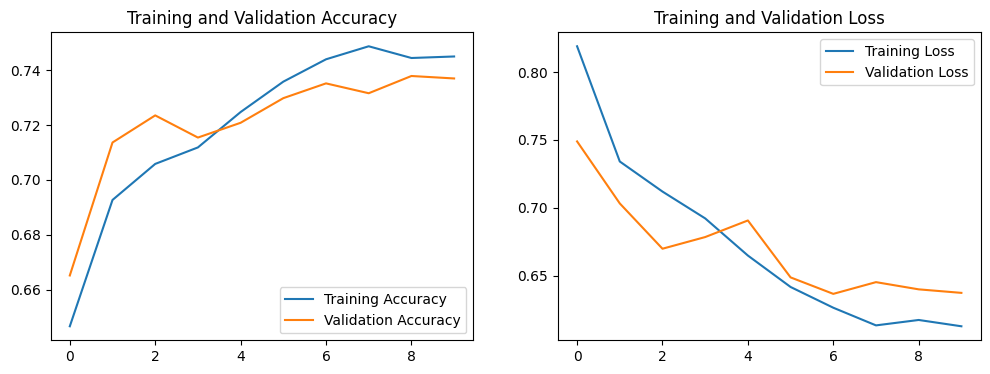

In [5]:

# -------------------- EVALUATION --------------------

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

# Predictions
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Confusion Matrix & Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_history(history)